Importation de Modules utiles et définitions de certains termes.

In [68]:
from scipy.constants import Avogadro, c, m_e, m_p, e, physical_constants
from pandas.plotting import table
from functools import partial, lru_cache
from timeit import timeit
import scipy.stats
import csv
import scipy.integrate as integrate
from scipy.integrate import quad
import pandas as pd
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, pi, ln, diff, simplify, sqrt
import logging


eV_to_MeV = 1e-6            #Convertion eV vers MeV.

m_p = m_p  * eV_to_MeV/e    # Masse du proton en MeV/c^2
m_e = m_e  * eV_to_MeV/e    # Masse de l'électron en MeV/c^2    # cm

r_e = physical_constants["classical electron radius"][0] * 1e2      # cm

<hr style="border-color:#D4D4D4">

## ***Question 1***

Exprimez la densité électronique $n_e$ d’un milieu en fonction de sa composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l’eau (liquide) et l’os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux.

In [69]:
n_e = lambda atomic_numbers, fractions_by_weight, rho, A: rho * Avogadro * np.sum(atomic_numbers * fractions_by_weight/A)

I_bone = 91.9 * eV_to_MeV                                                                                               # Mean Excitation Energy en MeV de l'eau liquide.
rho_bone = 1.85                                                                                                         # Densité de l'os Compact en g/cm^3
atomic_numbers_bone = np.array([1, 6, 7, 8, 12, 15, 16, 20])                                                            # Nombre atomique.
fractions_by_weight_bone = np.array([0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000])   # Fractions Massiques.
AtomicMasses_bone = np.array([1.007975, 12.0106, 14.006855, 15.99940, 24.3055, 30.973762, 32.0675, 40.078])             # Masses Atomiques.

n_e_bone = n_e(atomic_numbers_bone, fractions_by_weight_bone, rho_bone, AtomicMasses_bone)                              # Densité électronique de l'Os Compact

I_water = 75 * eV_to_MeV                                                                                                # Mean Excitation Energy en MeV de l'eau liquide.
rho_water = 1                                                                                                           # Densité de l'eau liquide en g/cm^3
atomic_numbers_water = np.array([1, 8])                                                                                 # Nombre atomique.
fractions_by_weight_water = np.array([0.111894, 0.888106])                                                              # Fractions Massiques.
AtomicMasses_water = np.array([1.008, 15.999])                                                                          # Masses Atomiques.

n_e_water = n_e(atomic_numbers_water, fractions_by_weight_water, rho_water, AtomicMasses_water)                         # Densité électronique de l'eau liquide

print(f"Les densités électroniques de l'os compact et de l'eau liquide sont respectivement de {n_e_bone} e-/cm\u00b3 et {n_e_water} e-/cm\u00b3.")

Les densités électroniques de l'os compact et de l'eau liquide sont respectivement de 5.905891191511755e+23 e-/cm³ et 3.342810286137214e+23 e-/cm³.


<hr style="border-color:#D4D4D4">

## ***Question 2***

Tracez les courbes du pouvoir d’arrêt collisionnel massique pour ces milieux en fonction de l’énergie cinétique (T). Pour expliciter la dépendance en T de Scol, utilisez les relations 9 et 10 ci-bas. Pour le graphique, utilisez une échelle logarithmique en abscisse. Vous trouverez les énergies moyennes d’excitation I de ces matériaux sur le site du NIST également. L’approximation d’une décélération continue (Continuous Slowing Down Approximation, CSDA) des protons dans la matière, en ligne droite, permet d’estimer leur portée dans le milieu considéré (la distance qu’ils peuvent parcourir avant d’avoir transféré au milieu la totalité de leur énergie cinétique initiale). Ici, seuls les transferts d’énergie vers les électrons du milieu sont considérés.

Équation 9 :
$$
T = (\gamma - 1) m_p c^2 \Rightarrow \gamma = \frac{T}{m_p c^2} + 1
$$
Équation 10 :
$$
\gamma = \frac{1}{\sqrt{1 - \beta^2}} \Rightarrow \gamma^2 \beta^2 = (\gamma^2 - 1)
$$


Certaines Équations sont utiles afin de faire ce problème :

Équation 3:
$$
T_e^{max} = \frac{2 m_e c^2 (\gamma^2 - 1)}{1 + 2 \gamma \frac{m_e}{m_p} + \left( \frac{m_e}{m_p} \right)^2}
$$
Équation 4:
$$
S_{col} = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \big[\ln\big(\frac{2 m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\big) - 2 \beta^2\big]
$$

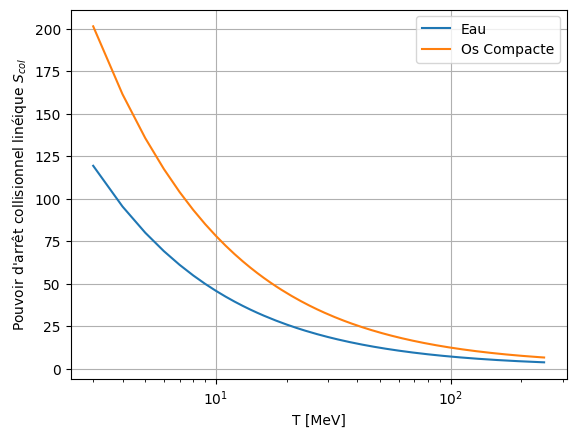

In [71]:
def gamma(T):   # Implémentation de l'équation 9.
    gamma = T/(m_p*c**2) + 1
    return gamma

def beta(T):    # implémentation de l'équation 10.
    beta = np.sqrt((gamma(T)**2 - 1)/gamma(T)**2)
    return beta

def t_max(T):   # implémentation de l'équation 3.
    t_max = (2*m_e*c**2 * (gamma(T)**2 - 1))/(1 + 2*(m_e/m_p)*gamma(T) + (m_e/m_p)**2)
    return t_max

def s_col(T, n_e, I_MeV):   # implémentation de l'équation 4.
    constant = 2 * np.pi * r_e**2 * m_e * c**2 * n_e
    s_col = constant * (1/beta(T)**2) * (np.log(2*m_e*c**2*beta(T)**2*gamma(T)**2*t_max(T)/I_MeV**2) - 2*beta(T)**2)
    return s_col

SCol_bone = partial(s_col, n_e=n_e_bone, I_MeV=I_bone)      # définition du pouvoir d'arrêt collisionnel pour l'os compact.

SCol_water = partial(s_col, n_e=n_e_water, I_MeV=I_water)   # définition du pouvoir d'arrêt collisionnel pour l'eau liquide.

T = np.linspace(3, 250, 248)
S_col_water = SCol_water(T)     # Calcul du pouvoir d'arrêt collisionnel pour l'eau liquide.
S_col_bone = SCol_bone(T)       # Calcul du pouvoir d'arrêt collisionnel pour l'os compact.

def plotit(T, bone=S_col_bone, water=S_col_water):      # Mise en graphique des pouvoirs d'arrêts.
    plt.plot(T, water, label="Eau")  # Tracé normal (pas semi-log sur X)
    plt.plot(T, bone, label="Os Compacte")
    plt.xlabel("T [MeV]")
    plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
    plt.xscale('log')  # Axe des y en échelle logarithmique
    plt.legend()
    plt.grid()
    plt.show()

plotit(T)



<hr style="border-color:#D4D4D4">

## ***Question 3***


Les données PSTAR sont données ici : https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html.


Pour l'eau liquide:

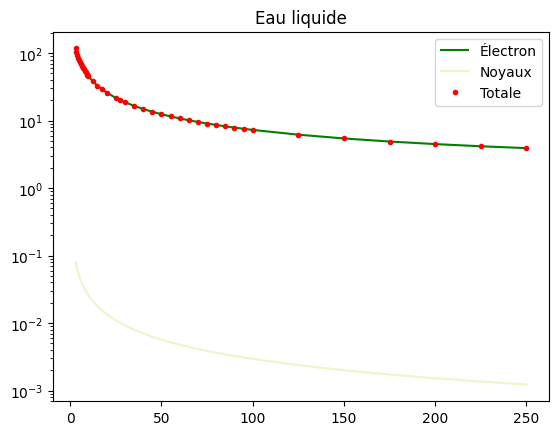

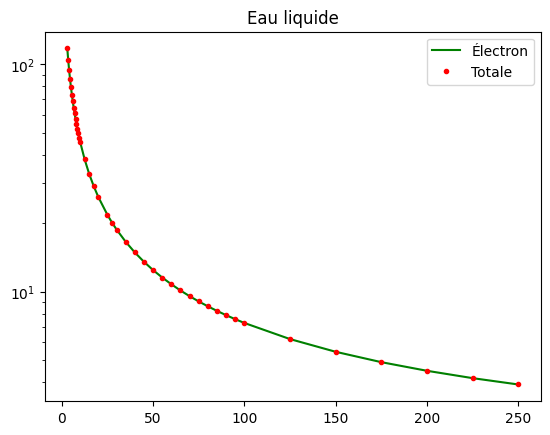

In [72]:
Ke_Mev_eau_liquide = [
    3.000E+00, 3.500E+00, 4.000E+00, 4.500E+00, 5.000E+00, 5.500E+00, 6.000E+00,
    6.500E+00, 7.000E+00, 7.500E+00, 8.000E+00, 8.500E+00, 9.000E+00, 9.500E+00,
    1.000E+01, 1.250E+01, 1.500E+01, 1.750E+01, 2.000E+01, 2.500E+01, 2.750E+01,
    3.000E+01, 3.500E+01, 4.000E+01, 4.500E+01, 5.000E+01, 5.500E+01, 6.000E+01,
    6.500E+01, 7.000E+01, 7.500E+01, 8.000E+01, 8.500E+01, 9.000E+01, 9.500E+01,
    1.000E+02, 1.250E+02, 1.500E+02, 1.750E+02, 2.000E+02, 2.250E+02, 2.500E+02
]

Stopping_power_Electronic_eau_liquide = [
    1.171E+02, 1.041E+02, 9.398E+01, 8.580E+01, 7.906E+01, 7.339E+01, 6.854E+01,
    6.434E+01, 6.068E+01, 5.744E+01, 5.456E+01, 5.199E+01, 4.966E+01, 4.756E+01,
    4.564E+01, 3.813E+01, 3.290E+01, 2.904E+01, 2.605E+01, 2.174E+01, 2.012E+01,
    1.875E+01, 1.656E+01, 1.487E+01, 1.353E+01, 1.244E+01, 1.154E+01, 1.078E+01,
    1.012E+01, 9.555E+00, 9.059E+00, 8.622E+00, 8.233E+00, 7.884E+00, 7.570E+00,
    7.286E+00, 6.190E+00, 5.443E+00, 4.901E+00, 4.491E+00, 4.169E+00, 3.910E+00
]

Stopping_power_Nuclear_eau_liquide = [
    7.972E-02, 6.916E-02, 6.113E-02, 5.481E-02, 4.970E-02, 4.549E-02, 4.195E-02,
    3.894E-02, 3.634E-02, 3.407E-02, 3.208E-02, 3.031E-02, 2.873E-02, 2.731E-02,
    2.603E-02, 2.111E-02, 1.778E-02, 1.538E-02, 1.356E-02, 1.098E-02, 1.003E-02,
    9.239E-03, 7.983E-03, 7.034E-03, 6.290E-03, 5.691E-03, 5.199E-03, 4.786E-03,
    4.435E-03, 4.134E-03, 3.871E-03, 3.641E-03, 3.437E-03, 3.255E-03, 3.092E-03,
    2.944E-03, 2.381E-03, 2.001E-03, 1.728E-03, 1.522E-03, 1.361E-03, 1.231E-03
]

Stopping_power_total_eau_liquide = [
    1.172E+02, 1.042E+02, 9.404E+01, 8.586E+01, 7.911E+01, 7.343E+01, 6.858E+01,
    6.438E+01, 6.071E+01, 5.747E+01, 5.460E+01, 5.202E+01, 4.969E+01, 4.759E+01,
    4.567E+01, 3.815E+01, 3.292E+01, 2.905E+01, 2.607E+01, 2.175E+01, 2.013E+01,
    1.876E+01, 1.656E+01, 1.488E+01, 1.354E+01, 1.245E+01, 1.154E+01, 1.078E+01,
    1.013E+01, 9.559E+00, 9.063E+00, 8.625E+00, 8.236E+00, 7.888E+00, 7.573E+00,
    7.289E+00, 6.192E+00, 5.445E+00, 4.903E+00, 4.492E+00, 4.170E+00, 3.911E+00
]


plt.title("Eau liquide")

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide,'g',label="Électron")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Nuclear_eau_liquide, 'y', alpha=0.2,label="Noyaux")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, '.r',label="Totale")
plt.legend()
plt.show()

plt.title("Eau liquide")

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide, 'g',label="Électron")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, '.r',label="Totale")
plt.legend()

plt.show()


Nous pouvons voir qu'il n'est pas nécessaire de considérer l'effet atomique. En effet, sa contribution est très minime. Le premier graph montre les contribution de toutes les parties alors que le deuxième graph montre le stopping power total et électronique.

Pour l'os compact:

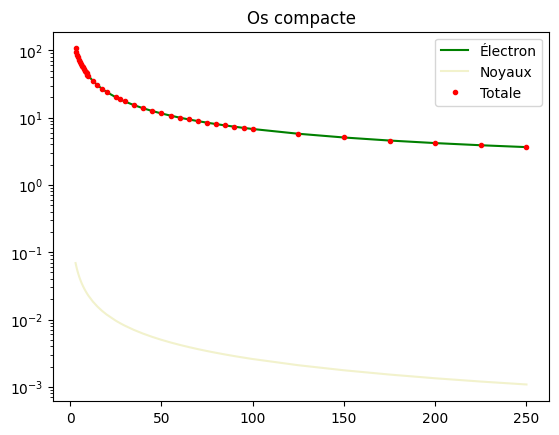

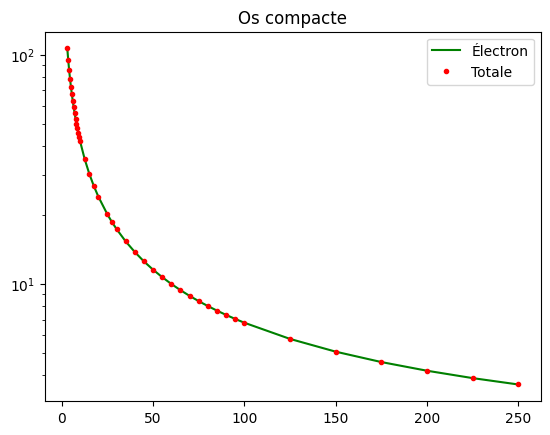

In [42]:

Ke_Mev_os_compact = [
    3.000E+00, 3.500E+00, 4.000E+00, 4.500E+00, 5.000E+00, 5.500E+00, 6.000E+00,
    6.500E+00, 7.000E+00, 7.500E+00, 8.000E+00, 8.500E+00, 9.000E+00, 9.500E+00,
    1.000E+01, 1.250E+01, 1.500E+01, 1.750E+01, 2.000E+01, 2.500E+01, 2.750E+01,
    3.000E+01, 3.500E+01, 4.000E+01, 4.500E+01, 5.000E+01, 5.500E+01, 6.000E+01,
    6.500E+01, 7.000E+01, 7.500E+01, 8.000E+01, 8.500E+01, 9.000E+01, 9.500E+01,
    1.000E+02, 1.250E+02, 1.500E+02, 1.750E+02, 2.000E+02, 2.250E+02, 2.500E+02
]

Stopping_power_Electronic_os_compact = [
    1.065E+02, 9.484E+01, 8.571E+01, 7.834E+01, 7.224E+01, 6.711E+01, 6.272E+01,
    5.892E+01, 5.560E+01, 5.266E+01, 5.005E+01, 4.771E+01, 4.560E+01, 4.368E+01,
    4.194E+01, 3.509E+01, 3.032E+01, 2.678E+01, 2.405E+01, 2.009E+01, 1.861E+01,
    1.735E+01, 1.533E+01, 1.378E+01, 1.254E+01, 1.154E+01, 1.071E+01, 1.000E+01,
    9.398E+00, 8.874E+00, 8.416E+00, 8.012E+00, 7.652E+00, 7.329E+00, 7.039E+00,
    6.776E+00, 5.760E+00, 5.068E+00, 4.566E+00, 4.185E+00, 3.886E+00, 3.645E+00
]

Stopping_power_Nuclear_os_compact = [
    6.903E-02, 5.994E-02, 5.303E-02, 4.759E-02, 4.318E-02, 3.955E-02, 3.649E-02,
    3.388E-02, 3.163E-02, 2.967E-02, 2.795E-02, 2.641E-02, 2.505E-02, 2.382E-02,
    2.271E-02, 1.844E-02, 1.554E-02, 1.345E-02, 1.187E-02, 9.619E-03, 8.793E-03,
    8.100E-03, 7.003E-03, 6.173E-03, 5.522E-03, 4.998E-03, 4.567E-03, 4.205E-03,
    3.898E-03, 3.633E-03, 3.403E-03, 3.201E-03, 3.022E-03, 2.862E-03, 2.719E-03,
    2.590E-03, 2.095E-03, 1.762E-03, 1.522E-03, 1.340E-03, 1.198E-03, 1.084E-03
]

Stopping_power_total_os_compact = [
    1.065E+02, 9.490E+01, 8.576E+01, 7.838E+01, 7.228E+01, 6.715E+01, 6.276E+01,
    5.896E+01, 5.563E+01, 5.269E+01, 5.008E+01, 4.774E+01, 4.562E+01, 4.371E+01,
    4.196E+01, 3.511E+01, 3.033E+01, 2.679E+01, 2.406E+01, 2.010E+01, 1.861E+01,
    1.736E+01, 1.534E+01, 1.378E+01, 1.255E+01, 1.155E+01, 1.071E+01, 1.001E+01,
    9.401E+00, 8.878E+00, 8.420E+00, 8.015E+00, 7.655E+00, 7.332E+00, 7.042E+00,
    6.778E+00, 5.762E+00, 5.070E+00, 4.567E+00, 4.186E+00, 3.887E+00, 3.646E+00
]


plt.title("Os compacte")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact,'g',label="Électron")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Nuclear_os_compact, 'y', alpha=0.2,label="Noyaux")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, '.r',label="Totale")
plt.legend()
plt.show()
plt.title("Os compacte")

plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact, 'g',label="Électron")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, '.r',label="Totale")
plt.legend()

plt.show()

<hr style="border-color:#D4D4D4">

## ***Question 4***

À partir de l'équation suivante $ \frac{S_{col}}{\rho} = - \left( \frac{1}{\rho} \frac{dT}{dx} \right)_{col} $ on peut réexprimer dx en fonction du reste. $$ dx = -\frac{dT}{S_{col}} $$ On obtient ensuite $$ x = -\int^{T_i}_0 \frac{dT}{S_{col}}$$

En prenant l'inverse du pouvoir d'arrêt, cela nous permet d'avoir les unités de longueurs par rapport de l'énergie. On intègre ensuite sur ces unités de longueurs pour obtenir l'entièreté de la porté.


In [73]:
@np.vectorize
@lru_cache(maxsize=None)
def inverse_scol_water(T):
    return 1/SCol_water(T)

@np.vectorize
@lru_cache(maxsize=None)
def inverse_scol_bone(T):
    return 1/SCol_bone(T)

<hr style="border-color:#D4D4D4">

## ***Question 5***

Il s'agit d'une équation compliqué, il n’existe pas de solution analytique générale permettant de relier directement l’énergie initiale d’un proton à sa portée dans un milieu donné. $\frac{1}{\ln(x)}$ ne s'intègre pas.

<hr style="border-color:#D4D4D4">

## ***Question 6***

Méthode du trapèse

In [44]:
def n_valeurs():
    puissance_de_2 = [2**i for i in range(1, 26)]
    return puissance_de_2

In [45]:
def trapeze_sans_erreur_optimise(Bone_water, N, a, b):
    h = (b - a) / N
    N = int(N)
    x = np.linspace(a + h, b - h, N - 1)
    y = Bone_water(x)
    I = h * (0.5 * y[0] + 0.5 * y[-1] + np.sum(y[1:-1]))
    return I

In [46]:
def trapeze_avec_erreur_optimise(water_bone, a, b, n_valeurs, tol):
    n_liste = []
    i_liste = []
    erreurs_liste = []

    I_avant = None

    for N in n_valeurs:
        # Points équidistants pour la subdivision
        x = np.linspace(a, b, N + 1)
        h = (b - a) / N

        # Calcul vectorisé de la somme des termes
        y = water_bone(x)
        I_maintenant = h * (0.5 * y[0] + 0.5 * y[-1] + np.sum(y[1:-1]))

        # Stocker les résultats
        n_liste.append(N)
        i_liste.append(I_maintenant)

        # Calcul de l'erreur si possible
        if I_avant is not None:
            erreur = abs(I_maintenant - I_avant) / 3
            erreurs_liste.append(erreur)

            print(f"N = {N}, I = {I_maintenant}, Erreur = {erreur}")

            # Vérifier la tolérance
            if erreur < tol:
                return I_maintenant, n_liste, i_liste, erreurs_liste
        else:
            erreurs_liste.append(None)  # Pas d'erreur pour la première approximation

        # Mise à jour de I_avant
        I_avant = I_maintenant

    return I_maintenant, n_liste, i_liste, erreurs_liste


Méthode de Romberg

In [47]:
def romberg_sans_erreur(water_bone, a, b, N):

    # Initialisation
    R = np.zeros((2, 2))  # Matrice de Romberg (seulement 2 x 2 nécessaire ici)

    # Calcul de R[0, 0] (première approximation avec trapèzes)
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)
    R[0, 0] = h * (water_bone(x[0]) + water_bone(x[-1])) / 2 + h * np.sum(water_bone(x[1:-1]))

    # Calcul de R[1, 0] (prochaine approximation avec un pas plus fin)
    N_fine = 2 * N  # Augmenter la subdivision
    h_fine = (b - a) / N_fine
    x_fine = np.linspace(a, b, N_fine + 1)
    R[1, 0] = h_fine * (water_bone(x_fine[0]) + water_bone(x_fine[-1])) / 2 + h_fine * np.sum(water_bone(x_fine[1:-1]))

    # Extrapolation de Richardson
    R[1, 1] = R[1, 0] + (R[1, 0] - R[0, 0]) / (4 - 1)

    # Calcul de l'erreur
    erreur = abs(R[1, 1] - R[0, 0])

    # Résultats finaux
    return R[1, 1]


In [48]:
def romberg_avec_erreur(water_bone, a, b, n_values=None, err_toléré=None):

    if n_values is None:
        n_values = [2 ** i for i in range(2, 27)]  # Par défaut, puissances de 2 de 4 à 2^26

    # Initialisation
    max_iter = len(n_values)  # Taille de la liste n_values
    R = np.zeros((max_iter, max_iter))  # Matrice de Romberg
    I = []  # Liste des valeurs d'intégrale (diagonale de R)
    erreurs = []  # Liste des erreurs
    N_liste = []  # Liste des subdivisions \( N \)

    # Calcul de R[0, 0] (première approximation)
    N = n_values[0]
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)
    R[0, 0] = h * (water_bone(x[0]) + water_bone(x[-1])) / 2 + h * np.sum(water_bone(x[1:-1]))
    I.append(R[0, 0])  # Ajouter la première estimation intégrale
    N_liste.append(N)

    # Remplissage de la matrice de Romberg
    for k in range(1, max_iter):
        N = n_values[k]
        h = (b - a) / N  # Calcul du pas
        x = np.linspace(a, b, N + 1)  # Points intermédiaires

        # Calcul des points intermédiaires pour la nouvelle subdivision
        R[k, 0] = h * (water_bone(x[0]) + water_bone(x[-1])) / 2 + h * np.sum(water_bone(x[1:-1]))

        # Extrapolation de Richardson
        for j in range(1, k + 1):
            R[k, j] = R[k, j - 1] + (R[k, j - 1] - R[k - 1, j - 1]) / (4 ** j - 1)

        # Ajout à la liste des estimations intégrales et des subdivisions
        I.append(R[k, k])  # Ajouter la valeur diagonale comme estimation intégrale
        N_liste.append(N)

        # Évaluation de l'erreur
        erreur = abs(R[k, k] - R[k - 1, k - 1])
        erreurs.append(erreur)

        # Arrêt si la précision souhaitée est atteinte
        if erreur < err_toléré:
            return N_liste, I, erreurs

    # Retourne les résultats si aucune tolérance n'est respectée avant la fin
    return N_liste, I, erreurs


Pour l'eau liquide

In [49]:
I_maintenant_Trapeze_eau, N_liste_trapeze_eau, I_eau_trapeze, erreur_eau_trapeze = trapeze_avec_erreur_optimise(inverse_scol_water, 3, 150, n_valeurs(), np.finfo(float).eps)

N = 4, I = 15.624824981075848, Erreur = 0.11218425416302935
N = 8, I = 15.718567811364574, Erreur = 0.031247610096241846
N = 16, I = 15.743901668289759, Erreur = 0.008444618975061621
N = 32, I = 15.750545617098046, Erreur = 0.0022146496027624827
N = 64, I = 15.752246221407278, Erreur = 0.000566868103077193
N = 128, I = 15.752675223919953, Erreur = 0.00014300083755832324
N = 256, I = 15.752782772519208, Erreur = 3.584953308492326e-05
N = 512, I = 15.752809679808557, Erreur = 8.96909644983642e-06
N = 1024, I = 15.752816407919049, Erreur = 2.2427034972830975e-06
N = 2048, I = 15.752818090027676, Erreur = 5.607028755368523e-07
N = 4096, I = 15.752818510559903, Erreur = 1.4017740923577549e-07
N = 8192, I = 15.752818615693277, Erreur = 3.5044458002175816e-08
N = 16384, I = 15.752818641976639, Erreur = 8.761120421733418e-09
N = 32768, I = 15.75281864854748, Erreur = 2.1902805495225644e-09
N = 65536, I = 15.752818650190193, Erreur = 5.475708775293242e-10
N = 131072, I = 15.752818650600869, Err

In [50]:
N_liste_romberg_eau, I_eau_romberg, erreurs_eau_romberg = romberg_avec_erreur(inverse_scol_water, 3, 150, n_values=n_valeurs(), err_toléré=np.finfo(float).eps)

Pour l'os compact

In [51]:
I_maintenant_Trapeze_bone, N_liste_trapeze_bone, I_bone_trapeze, erreur_bone_trapeze = trapeze_avec_erreur_optimise(inverse_scol_bone, 3, 150, n_valeurs(), np.finfo(float).eps)

N = 4, I = 9.08415350939609, Erreur = 0.06580303912714432
N = 8, I = 9.13924059312755, Erreur = 0.01836236124381981
N = 16, I = 9.154147595878094, Erreur = 0.004969000916847932
N = 32, I = 9.158060148104108, Erreur = 0.0013041840753379812
N = 64, I = 9.159061978729111, Erreur = 0.00033394354166797296
N = 128, I = 9.15931473599308, Erreur = 8.425242132285386e-05
N = 256, I = 9.159378102922771, Erreur = 2.1122309896999997e-05
N = 512, I = 9.159393956647996, Erreur = 5.284575075018931e-06
N = 1024, I = 9.159397920846096, Erreur = 1.3213993668159674e-06
N = 2048, I = 9.159398911943832, Erreur = 3.3036591181219893e-07
N = 4096, I = 9.159399159721284, Erreur = 8.259248396313978e-08
N = 8192, I = 9.159399221665836, Erreur = 2.0648184199482483e-08
N = 16384, I = 9.159399237151986, Erreur = 5.1620497506140355e-09
N = 32768, I = 9.159399241023523, Erreur = 1.2905125856832456e-09
N = 65536, I = 9.159399241991409, Erreur = 3.226284424802846e-10
N = 131072, I = 9.15939924223338, Erreur = 8.06572586

In [52]:
N_liste_romberg_bone, I_bone_romberg, erreurs_bone_romberg = romberg_avec_erreur(inverse_scol_bone, 3, 150, n_values=n_valeurs(), err_toléré=np.finfo(float).eps)

<hr style="border-color:#D4D4D4">

## ***Question 7***

Tracez un graphique de la portée calculée par chaque méthode en fonction du nombre d’échantillons (de tranches) considéré. Le même graphique rapportera l’estimation pratique de l’erreur d’approximation pour les deux méthodes (avec une échelle différente en ordonnée). Votre graphique comprendra des points choisis de façon à bien représenter le comportement de vos algorithmes (des échelles logarithmiques pourraient être nécessaires). Doubler le nombre de tranches entre chaque évaluation pourrait s’avérer judicieux.

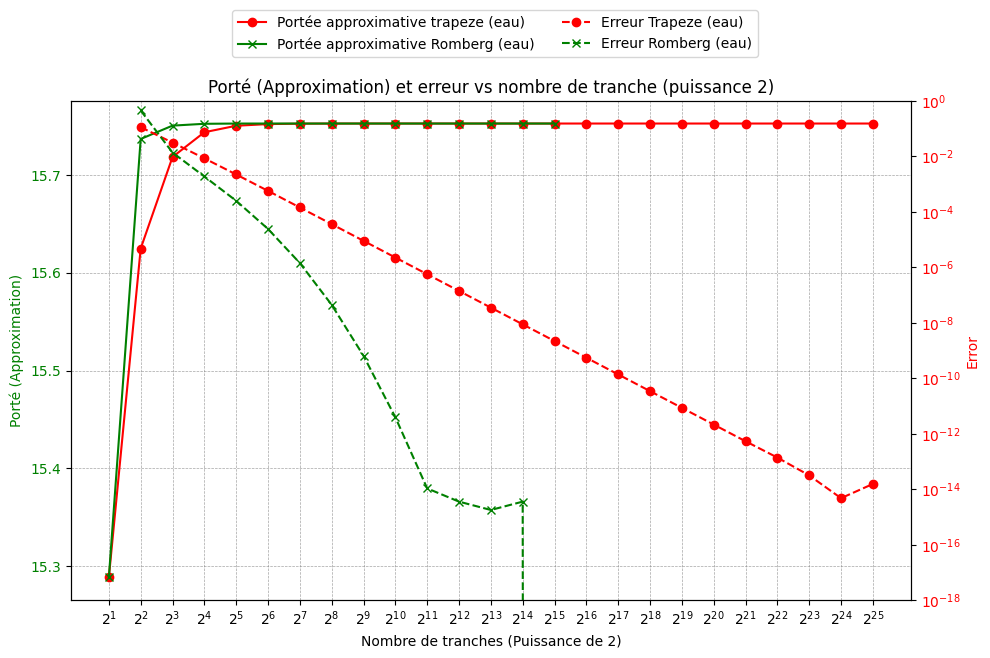

In [53]:
N = N_liste_trapeze_eau

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Nombre de tranches (Puissance de 2)")
ax1.set_ylabel("Porté (Approximation)", color="green")  # y-axis de gauche

ax1.plot(N, I_eau_trapeze, label="Portée approximative trapeze (eau)", marker="o", color="red")
ax1.plot(N_liste_romberg_eau, I_eau_romberg, label="Portée approximative Romberg (eau)", marker="x", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

ax2 = ax1.twinx()
ax2.set_ylabel("Error", color="red")  # y-axis de droite
ax2.plot(N, erreur_eau_trapeze, label="Erreur Trapeze (eau)", marker="o", linestyle="--", color="red")
ax2.plot(N_liste_romberg_eau[1:], erreurs_eau_romberg, label="Erreur Romberg (eau)", marker="x", linestyle="--", color="green")
ax2.set_yscale('log')
ax2.set_ylim(1e-18, 1)
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Porté (Approximation) et erreur vs nombre de tranche (puissance 2)")
ax1.set_xscale('log', base=2)  # Logarithmique
ax1.set_xticks(N)

fig.tight_layout()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()


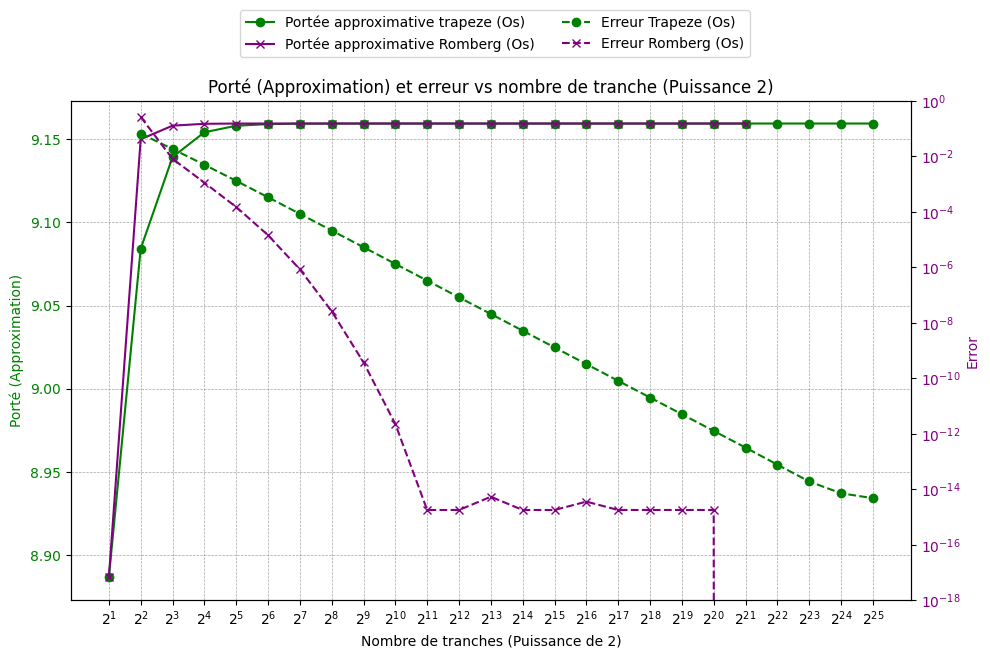

In [54]:
N = N_liste_trapeze_bone

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Nombre de tranches (Puissance de 2)")
ax1.set_ylabel("Porté (Approximation)", color="green")  # y-axis de gauche

ax1.plot(N, I_bone_trapeze, label="Portée approximative trapeze (Os)", marker="o", color="green")
ax1.plot(N_liste_romberg_bone, I_bone_romberg, label="Portée approximative Romberg (Os)", marker="x", color="purple")
ax1.tick_params(axis="y", labelcolor="green")
ax1.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

ax2 = ax1.twinx()
ax2.set_ylabel("Error", color="purple")  # y-axis de droite
ax2.plot(N, erreur_bone_trapeze, label="Erreur Trapeze (Os)", marker="o", linestyle="--", color="green")
ax2.plot(N_liste_romberg_bone[1:], erreurs_bone_romberg, label="Erreur Romberg (Os)", marker="x", linestyle="--", color="purple")
ax2.set_yscale('log')
ax2.set_ylim(1e-18, 1)
ax2.tick_params(axis="y", labelcolor="purple")

plt.title("Porté (Approximation) et erreur vs nombre de tranche (Puissance 2)")
ax1.set_xscale('log', base=2)  # Logarithmique
ax1.set_xticks(N)

fig.tight_layout()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()

<hr style="border-color:#D4D4D4">

## ***Question 8***
la dérivé de $ S^{-1}_{col}$, selon mon calcul à la main est : $$  \frac{d S^{-1}_{col}}{dT} = \frac{-1}{2\pi r_e^2 m_e c^4 n_e m_p } 
\left( \frac{\left(\frac{-2\gamma^3}{(\gamma^2 - 1)^2} + \frac{2\gamma}{\gamma^2 -1}\right) 
\ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) + \frac{1}{\gamma^2 -1} \left( 4\gamma -\frac{\delta}{b+\delta \gamma}\right) }{\left[ \ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) \frac{\gamma^2}{\gamma^2 -1} -2\right]^2}\right)$$

In [55]:
T, m_p, c, r_e, m_e, n_e, I = symbols('T m_p c r_e m_e n_e I', positive=True)
U = 2 * pi * r_e * m_e * c**2 * n_e
gamma = ((T / (m_p * c**2)) + 1)
beta = sqrt((gamma**2 - 1)/gamma**2)
T_max = (2 * m_e * c**2 * (gamma**2 - 1))/(1 + 2*gamma *(m_e/m_p) + (m_e/m_p)**2)


S_col = U * (1 / beta**2) * (
    ln((2*m_e*c**2 *beta**2 * gamma**2 * T_max) / (I**2) ) - 2 * beta**2
)

dSidT = diff(1/S_col, T)

def const(Tval=3 , Ival=I_bone, ne=n_e_bone):
    constants = {
        c: 299792458.0 * 1e2,  # cm/s
        m_e: 9.10938356e-31 * 1e3,  # g
        m_p: 1.6726219e-27 * 1e3,  # g
        n_e: ne,  # densité electronique
        r_e: 2.8179403e-15 * 1e2,  # cm
        T: Tval, # MeV
        I: Ival # MeV
    }
    return constants

def f(x,isbone=True):
    if isbone:
        cstx = const(Tval=x)
    else:
        cstx = const(Tval=x, Ival=I_water, ne = n_e_water)
    return dSidT.subs(cstx)

In [56]:
def epsilontrapz(f, a, b, N, isbone=True):
    h = (a-b)/2**N
    eps = 1/12 * h*2 * np.abs(f(a,isbone=isbone) - f(b,isbone=isbone))
    return eps.evalf()

<hr style="border-color:#D4D4D4">

## ***Question 9***

Rapportez vos portées calulées dans un tableau, qui comprendra aussi les erreurs d’approximation calculées (pour la méthode des trapezes) et évalué de façon pratique (pour la méthode des trapèzes et de Romberg). Il s’agit essentiellement des résultats d́eja obtenus (auxquels on ajoute les erreurs calculées pour la methode des trapèzes). Commentéz vos résultats.


C:\Users\micha\AppData\Local\Temp\ipykernel_30032\2949896723.py:1: UserWarning: legacy printing option can currently only be '1.13', '1.21', or `False`
  np.set_printoptions(legacy='1.25')


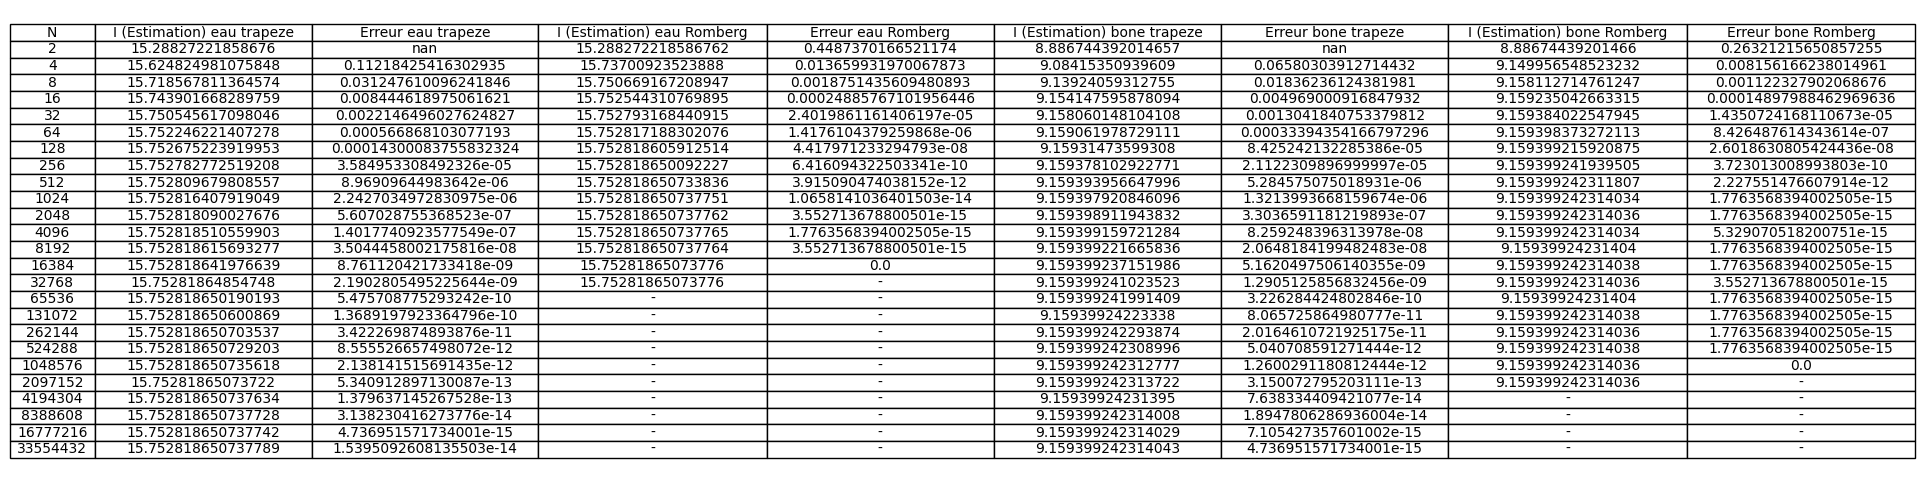

In [57]:
np.set_printoptions(legacy='1.25')

eau_trapeze = {
    "N": N_liste_trapeze_eau,
    "I (Estimation)": I_eau_trapeze,
    "Erreur": erreur_eau_trapeze
}

eau_romberg = {
    "N": N_liste_romberg_eau,
    "I (Estimation)": I_eau_romberg,
    "Erreur": erreurs_eau_romberg
}

bone_trapeze = {
    "N": N_liste_trapeze_bone,
    "I (Estimation)": I_bone_trapeze,
    "Erreur": erreur_bone_trapeze
}

bone_romberg = {
    "N": N_liste_romberg_bone,
    "I (Estimation)": I_bone_romberg,
    "Erreur": erreurs_bone_romberg
}

# Trouver la longueur maximale parmi les listes de tous les dictionnaires
longueur_max = max(
    len(eau_trapeze["N"]),
    len(eau_romberg["N"]),
    len(bone_trapeze["N"]),
    len(bone_romberg["N"])
)

# Fonction pour compléter les listes courtes avec des valeurs "-"
def completer_liste(liste, longueur_cible):
    return liste + ["-"] * (longueur_cible - len(liste))

# Liste unique pour les valeurs de N
N_values = completer_liste(list(eau_trapeze["N"]), longueur_max)

# Simplification en utilisant la liste partagée pour les valeurs de 'N'
Dictionnaire = {
    "N": N_values,
    "I (Estimation) eau trapeze": completer_liste(list(eau_trapeze["I (Estimation)"]), longueur_max),
    "Erreur eau trapeze": completer_liste(list(eau_trapeze["Erreur"]), longueur_max),
    "I (Estimation) eau Romberg": completer_liste(list(eau_romberg["I (Estimation)"]), longueur_max),
    "Erreur eau Romberg": completer_liste(list(eau_romberg["Erreur"]), longueur_max),
    "I (Estimation) bone trapeze": completer_liste(list(bone_trapeze["I (Estimation)"]), longueur_max),
    "Erreur bone trapeze": completer_liste(list(bone_trapeze["Erreur"]), longueur_max),
    "I (Estimation) bone Romberg": completer_liste(list(bone_romberg["I (Estimation)"]), longueur_max),
    "Erreur bone Romberg": completer_liste(list(bone_romberg["Erreur"]), longueur_max)
}

# Création du DataFrame à partir du dictionnaire
table_combine = pd.DataFrame(Dictionnaire)

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(12, 6))  # Taille de la figure

# Masquer les axes
ax.axis("off")  # Supprime les bordures et numéros

# Affichage du tableau (ax.table pour matplotlib)
mpl_table = ax.table(
    cellText=table_combine.values,  # Valeurs du DataFrame
    colLabels=table_combine.columns,  # Noms des colonnes
    loc="center",  # Centrer le tableau sur la figure
    cellLoc="center"  # Centrer le contenu des cellules
)

# Ajustement de la figure et du tableau
mpl_table.auto_set_font_size(False)  # Autorise le contrôle de la taille des polices
mpl_table.set_fontsize(10)  # Définir une taille de police
mpl_table.auto_set_column_width(col=list(range(len(table_combine.columns))))  # Ajustement automatique des colonnes

# Afficher la figure
plt.show()


<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Optimisation**
## ***Question 10***

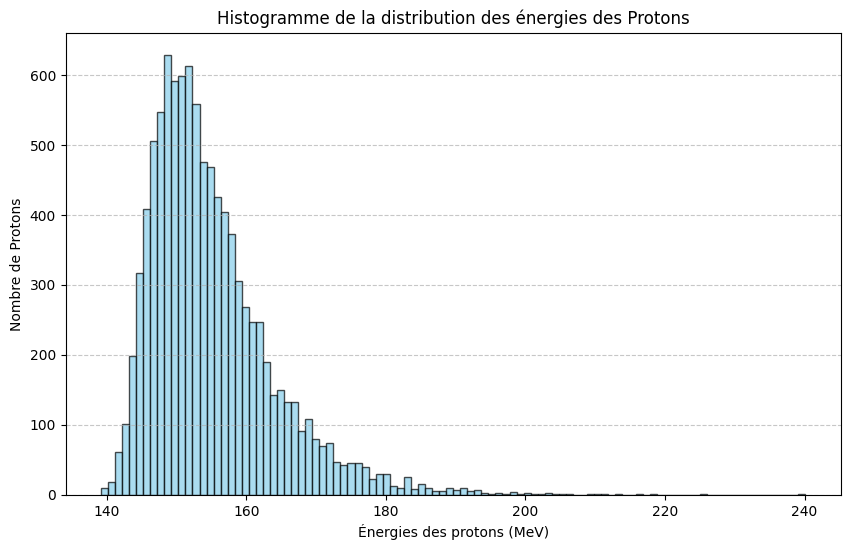

In [77]:
energy_proton = scipy.stats.moyal.rvs(loc = 150, scale = 4, size = 10000)

# Trouver les bornes de la distribution
plt.figure(figsize=(10, 6))
plt.hist(energy_proton, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogramme de la distribution des énergies des Protons")
plt.xlabel("Énergies des protons (MeV)")
plt.ylabel("Nombre de Protons")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<hr style="border-color:#D4D4D4">

## ***Question 11***

In [59]:
I_final_trapeze_water_11, N_trapeze_water_11, I_trapeze_water_11, erreur_trapeze_water_11 = trapeze_avec_erreur_optimise(inverse_scol_water, 3, 150, n_valeurs(), 1.49e-8)

I_final_trapeze_bone_11, N_trapeze_bone_11, I_trapeze_bone_11, erreur_trapreze_bone_11 = trapeze_avec_erreur_optimise(inverse_scol_bone, 3, 150, n_valeurs(), 1.49e-8)

N_romberg_water_11, I_romberg_water_11, erreurs_romberg_water_11 = romberg_avec_erreur(inverse_scol_water, 3, 150, n_values=n_valeurs(), err_toléré=1.49e-8)

N_romberg_bone_11, I_romberg_bone_11, erreurs_romberg_bone_11 = romberg_avec_erreur(inverse_scol_bone, 3, 150, n_values=n_valeurs(), err_toléré=1.49e-8)

def interpolation_lineaire(N1, E1, N2, E2, erreur_cible):
   # Relation de la droite entre (log(N), log(erreur)) pour estimer N
   logN1, logN2 = np.log(N1), np.log(N2)
   logE1, logE2 = np.log(E1), np.log(E2)
   pente = (logE2 - logE1) / (logN2 - logN1)  # Pente (variation logarithmique)
   logNcible = logN1 + (np.log(erreur_cible) - logE1) / pente  # Point cible
   return np.exp(logNcible)  # Retourner N estimée

N_exact = interpolation_lineaire(8192, 2.014915760166029e-08, 16384, 5.037293249188224e-09, 1.48e-8)
print(f"N interpolé pour Os Compact et Eau liquide pour trapeze: {N_exact}")

print(f"La valeurs de N pour romberg eau liquide pour atteindre la tolérance de Quad est {N_romberg_bone_11[-2]}")

print(f"La valeurs de N pour romberg Os compact pour atteindre la tolérance de Quad est {N_romberg_bone_11[-2]}")

N = 4, I = 15.624824981075848, Erreur = 0.11218425416302935
N = 8, I = 15.718567811364574, Erreur = 0.031247610096241846
N = 16, I = 15.743901668289759, Erreur = 0.008444618975061621
N = 32, I = 15.750545617098046, Erreur = 0.0022146496027624827
N = 64, I = 15.752246221407278, Erreur = 0.000566868103077193
N = 128, I = 15.752675223919953, Erreur = 0.00014300083755832324
N = 256, I = 15.752782772519208, Erreur = 3.584953308492326e-05
N = 512, I = 15.752809679808557, Erreur = 8.96909644983642e-06
N = 1024, I = 15.752816407919049, Erreur = 2.2427034972830975e-06
N = 2048, I = 15.752818090027676, Erreur = 5.607028755368523e-07
N = 4096, I = 15.752818510559903, Erreur = 1.4017740923577549e-07
N = 8192, I = 15.752818615693277, Erreur = 3.5044458002175816e-08
N = 16384, I = 15.752818641976639, Erreur = 8.761120421733418e-09
N = 4, I = 9.08415350939609, Erreur = 0.06580303912714432
N = 8, I = 9.13924059312755, Erreur = 0.01836236124381981
N = 16, I = 9.154147595878094, Erreur = 0.0049690009168

In [60]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

min_value = 3

# Configurer le niveau de journalisation
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

result_trapeze = np.zeros_like(energy_proton, dtype=np.float32)
result_romberg = np.zeros_like(energy_proton, dtype=np.float32)
result_quad = np.zeros_like(energy_proton, dtype=np.float32)

def quad_method(fc ,energy):
    return integrate.quad(fc, min_value, energy)[0]

# Calcul avec la méthode des trapèzes
def trapeze_method(fc):
    for i, energy in enumerate(energy_proton):
        if i % 100 == 0:
            logging.info(f"[Trapèze] Calcul proton {i + 1}/{len(energy_proton)} : énergie = {energy}")
        result_trapeze[i] = trapeze_sans_erreur_optimise(fc, 9559, min_value, energy)


# Calcul avec la méthode de Romberg
def romberg_method(fc):
    for i, energy in enumerate(energy_proton):
        if i % 100 == 0:
            logging.info(f"[Romberg] Calcul proton {i + 1}/{len(energy_proton)} : énergie = {energy}")
        result_romberg[i] = romberg_sans_erreur(fc, min_value, energy, 256)


# Calcul avec scipy.integrate.quad
def quad_comp(fc):
    for i, energy in enumerate(energy_proton):
        if i % 100 == 0:
            logging.info(f"[Quad] Calcul proton {i + 1}/{len(energy_proton)} : énergie = {energy}")
        result_quad[i] = quad_method(fc, energy)



In [79]:
## Nombre total de protons (énergies)
n_protons = len(energy_proton)

time_trapeze = timeit(lambda: trapeze_method(inverse_scol_water), number=1)
time_romberg = timeit(lambda: romberg_method(inverse_scol_water), number=1)
time_quad = timeit(lambda: quad_comp(inverse_scol_water), number=1)

# Calcul des protons par seconde
protons_per_second_trapeze = n_protons / time_trapeze
protons_per_second_romberg = n_protons / time_romberg
protons_per_second_quad = n_protons / time_quad

# Résultats affichés
print("Temps de calcul et protons par seconde pour eau liquide:")
print(f"Méthode Trapèze : {time_trapeze:.2f} secondes, {protons_per_second_trapeze:.2f} protons/sec")
print(f"Méthode Romberg : {time_romberg:.2f} secondes, {protons_per_second_romberg:.2f} protons/sec")
print(f"SciPy Quad : {time_quad:.2f} secondes, {protons_per_second_quad:.2f} protons/sec")


2025-02-21 21:36:55,013 - [Trapèze] Calcul proton 1/10000 : énergie = 148.19326535824152
2025-02-21 21:37:00,438 - [Trapèze] Calcul proton 101/10000 : énergie = 161.9900144425649
2025-02-21 21:37:05,765 - [Trapèze] Calcul proton 201/10000 : énergie = 151.80376963714278
2025-02-21 21:37:11,154 - [Trapèze] Calcul proton 301/10000 : énergie = 153.6435761015214
2025-02-21 21:37:16,481 - [Trapèze] Calcul proton 401/10000 : énergie = 160.07389668296977
2025-02-21 21:37:21,822 - [Trapèze] Calcul proton 501/10000 : énergie = 151.6445767724686
2025-02-21 21:37:27,149 - [Trapèze] Calcul proton 601/10000 : énergie = 143.3665078031059
2025-02-21 21:37:33,552 - [Trapèze] Calcul proton 701/10000 : énergie = 157.01796094053188
2025-02-21 21:37:38,925 - [Trapèze] Calcul proton 801/10000 : énergie = 148.69625114007306
2025-02-21 21:37:44,203 - [Trapèze] Calcul proton 901/10000 : énergie = 186.6574050702414
2025-02-21 21:37:49,463 - [Trapèze] Calcul proton 1001/10000 : énergie = 169.2736592929267
2025-0

Temps de calcul et protons par seconde pour eau liquide:
Méthode Trapèze : 537.34 secondes, 18.61 protons/sec
Méthode Romberg : 30.56 secondes, 327.20 protons/sec
SciPy Quad : 10.64 secondes, 939.53 protons/sec


In [ ]:
# Nombre total de protons (énergies)
n_protons = len(energy_proton)

time_trapeze = timeit(lambda: trapeze_method(inverse_scol_bone), number=1)
time_romberg = timeit(lambda: romberg_method(inverse_scol_bone), number=1)
time_quad = timeit(lambda: quad_comp(inverse_scol_bone), number=1)

# Calcul des protons par seconde
protons_per_second_trapeze = n_protons / time_trapeze
protons_per_second_romberg = n_protons / time_romberg
protons_per_second_quad = n_protons / time_quad

# Résultats affichés
print("Temps de calcul et protons par seconde pour Os Compact:")
print(f"Méthode Trapèze : {time_trapeze:.2f} secondes, {protons_per_second_trapeze:.2f} protons/sec")
print(f"Méthode Romberg : {time_romberg:.2f} secondes, {protons_per_second_romberg:.2f} protons/sec")
print(f"SciPy Quad : {time_quad:.2f} secondes, {protons_per_second_quad:.2f} protons/sec")

2025-02-21 16:07:52,936 - [Trapèze] Calcul photon 1/10000 : énergie = 162.3661262668354
2025-02-21 16:08:03,682 - [Trapèze] Calcul photon 101/10000 : énergie = 148.03581937894845
2025-02-21 16:08:09,588 - [Trapèze] Calcul photon 201/10000 : énergie = 147.95595030209796
2025-02-21 16:08:15,211 - [Trapèze] Calcul photon 301/10000 : énergie = 150.75504659732616
2025-02-21 16:08:20,837 - [Trapèze] Calcul photon 401/10000 : énergie = 152.6077630051582
2025-02-21 16:08:26,637 - [Trapèze] Calcul photon 501/10000 : énergie = 150.26687435831556
2025-02-21 16:08:32,354 - [Trapèze] Calcul photon 601/10000 : énergie = 151.00846560140965
2025-02-21 16:08:38,032 - [Trapèze] Calcul photon 701/10000 : énergie = 146.81282814118967
2025-02-21 16:08:43,663 - [Trapèze] Calcul photon 801/10000 : énergie = 142.06380804618635
2025-02-21 16:08:49,314 - [Trapèze] Calcul photon 901/10000 : énergie = 153.4761109434254
2025-02-21 16:08:55,033 - [Trapèze] Calcul photon 1001/10000 : énergie = 147.32478786695847
202

Temps de calcul et protons par seconde pour Os Compact:
Méthode Trapèze : 619.10 secondes, 16.15 protons/sec
Méthode Romberg : 34.10 secondes, 293.28 protons/sec
SciPy Quad : 2.93 secondes, 3408.55 protons/sec


<hr style="border-color:#D4D4D4">

## ***Question 12***

2025-02-21 02:21:28,599 - [Quad] Calcul photon 1/10000 : énergie = 145.39228729905471
2025-02-21 02:21:28,653 - [Quad] Calcul photon 101/10000 : énergie = 153.26442184100995
2025-02-21 02:21:28,714 - [Quad] Calcul photon 201/10000 : énergie = 143.5423135941582
2025-02-21 02:21:28,775 - [Quad] Calcul photon 301/10000 : énergie = 161.08741091042592
2025-02-21 02:21:28,829 - [Quad] Calcul photon 401/10000 : énergie = 144.31511996231782
2025-02-21 02:21:28,879 - [Quad] Calcul photon 501/10000 : énergie = 168.48928772384676
2025-02-21 02:21:28,938 - [Quad] Calcul photon 601/10000 : énergie = 198.54844386530033
2025-02-21 02:21:28,985 - [Quad] Calcul photon 701/10000 : énergie = 145.02857488807203
2025-02-21 02:21:29,032 - [Quad] Calcul photon 801/10000 : énergie = 151.9601808537013
2025-02-21 02:21:29,074 - [Quad] Calcul photon 901/10000 : énergie = 163.0532894358184
2025-02-21 02:21:29,119 - [Quad] Calcul photon 1001/10000 : énergie = 150.02234376387457
2025-02-21 02:21:29,163 - [Quad] Cal

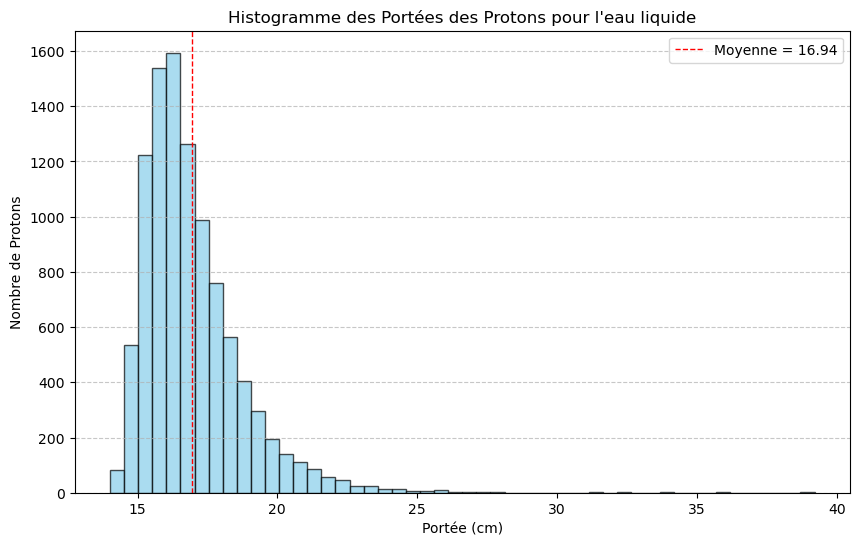

Moyenne: 16.94
Écart-type: 8.84


In [ ]:
quad_comp(inverse_scol_water)

# Tracé de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(result_quad, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogramme des Portées des Protons pour l'eau liquide")
plt.xlabel("Portée (cm)")
plt.ylabel("Nombre de Protons")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calcul des statistiques descriptives
mean = np.mean(result_quad)
std_dev = np.std(energy_proton)
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f"Moyenne = {mean:.2f}")
plt.legend()
plt.show()

# Anecdote : Affichage des statistiques pour commentaire
print(f"Moyenne: {mean:.2f}")
print(f"Écart-type: {std_dev:.2f}")



2025-02-21 02:21:38,680 - [Quad] Calcul photon 1/10000 : énergie = 145.39228729905471
2025-02-21 02:21:38,725 - [Quad] Calcul photon 101/10000 : énergie = 153.26442184100995
2025-02-21 02:21:38,767 - [Quad] Calcul photon 201/10000 : énergie = 143.5423135941582
2025-02-21 02:21:38,809 - [Quad] Calcul photon 301/10000 : énergie = 161.08741091042592
2025-02-21 02:21:38,854 - [Quad] Calcul photon 401/10000 : énergie = 144.31511996231782
2025-02-21 02:21:38,898 - [Quad] Calcul photon 501/10000 : énergie = 168.48928772384676
2025-02-21 02:21:38,941 - [Quad] Calcul photon 601/10000 : énergie = 198.54844386530033
2025-02-21 02:21:38,987 - [Quad] Calcul photon 701/10000 : énergie = 145.02857488807203
2025-02-21 02:21:39,035 - [Quad] Calcul photon 801/10000 : énergie = 151.9601808537013
2025-02-21 02:21:39,081 - [Quad] Calcul photon 901/10000 : énergie = 163.0532894358184
2025-02-21 02:21:39,123 - [Quad] Calcul photon 1001/10000 : énergie = 150.02234376387457
2025-02-21 02:21:39,165 - [Quad] Cal

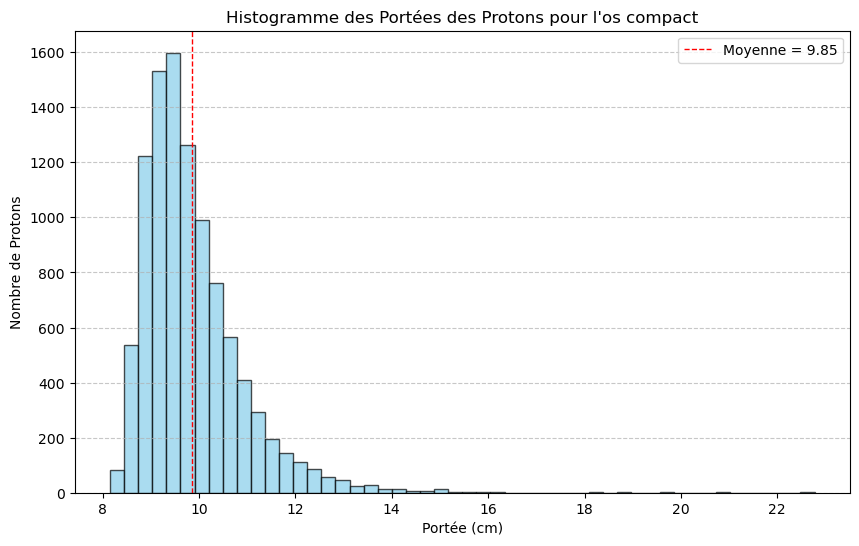

Moyenne: 9.85
Écart-type: 8.84


In [ ]:
# Q.12
quad_comp(inverse_scol_bone)

# Tracé de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(result_quad, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogramme des Portées des Protons pour l'os compact")
plt.xlabel("Portée (cm)")
plt.ylabel("Nombre de Protons")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calcul des statistiques descriptives
mean = np.mean(result_quad)
std_dev = np.std(energy_proton)
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f"Moyenne = {mean:.2f}")

plt.legend()
plt.show()

# Anecdote : Affichage des statistiques pour commentaire
print(f"Moyenne: {mean:.2f}")
print(f"Écart-type: {std_dev:.2f}")


<hr style="border-color:#D4D4D4">

## ***Question 13***

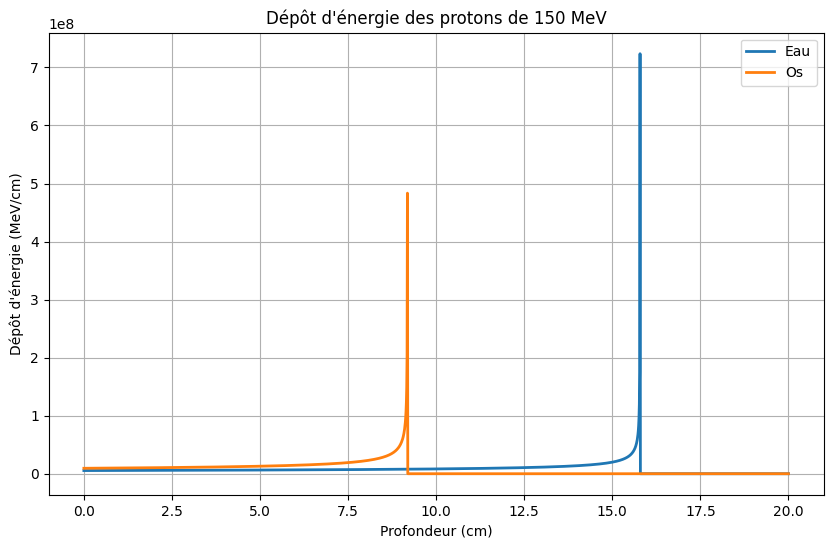

In [78]:
def depot_energie(T_initial_MeV, depths, n_e_material, I):
    T = T_initial_MeV
    deposition = []
    dx = (depths[1] - depths[0])  # cm

    for depth in depths:
        if T < 50 * eV_to_MeV:  # Limite d'énergie cinétique à 50 MeV
            deposition.append(0)
            continue

        dE = s_col(T, n_e_material, I) * dx  # Appel à la fonction existante
        deposition.append(dE / (eV_to_MeV * dx))  # Conversion pour MeV/cm

        T = max(T - dE, 0)  # Mise à jour de l'énergie résiduelle

    return np.array(deposition)

def plot_energie_depot(T_initial, depths):
    # Calcul du dépôt d'énergie pour l'eau et les os
    dep_water = depot_energie(T_initial, depths, n_e_water, I_water)
    dep_bone = depot_energie(T_initial, depths, n_e_bone, I_bone)

    # Tracé des courbes
    plt.figure(figsize=(10, 6))
    plt.plot(depths, dep_water, label="Eau", linewidth=2)
    plt.plot(depths, dep_bone, label="Os", linewidth=2)
    plt.xlabel("Profondeur (cm)")
    plt.ylabel("Dépôt d'énergie (MeV/cm)")
    plt.title(f"Dépôt d'énergie des protons de {T_initial} MeV")
    plt.grid(True)
    plt.legend()
    plt.show()


depths = np.linspace(0, 20, 2000)  # Profondeurs de 0 à 20 cm
plot_energie_depot(150, depths)



<hr style="border-color:#D4D4D4">

## ***Question 14***
### On nomme cette courbe le pic de Bragg. En déduire l'intérêt des protons en radiothérapie.


Contrairement aux photons ou aux électrons, qui perdent leur énergie petit à petit, les protons ont un comportement bien différent : ils déposent d’abord très peu d’énergie, puis lâchent quasiment tout d’un coup juste avant de s’arrêter. Du moins c'est ce qu'on observe dans la courbe de Bragg.

C’est très utile en radiothérapie, parce que ça permet de viser une tumeur avec une précision chirurgicale, sans trop toucher les tissus sains autour. C’est exactement ce qu’on recherche pour traiter efficacement sans causer trop de dégâts collatéraux.


<hr style="border-color:#D4D4D4">

## ***Question 15***
### Selon vous, est-il nécessaire de calculer les portées jusqu'à la precision machine en protonthérapie? Pourquoi?

Non, la précision La taille des cellules humaines varie en fonction de leur type et de leur fonction. En moyenne, une cellule humaine mesure environ 15 micromètres (µm) de diamètre.
 Cependant, cette dimension peut fluctuer considérablement. Par exemple, les globules rouges ont un diamètre d'environ 7 à 8 µm, tandis que les ovules, qui sont parmi les plus grandes cellules humaines, atteignent environ 100 µm de diamètre.

La taille des cellules humaines varie en fonction de leur type et de leur fonction. En moyenne, une cellule humaine mesure environ **15 micromètres (µm)** de diamètre ([source](https://www.assistancescolaire.com/eleve/1ST2S/biologie-et-physiopathologie-humaines/reviser-le-cours/1st2s_bio02)).

La précision machine est de l'ordre de $10^{-16}$, ce qui représente une exagération d’environ $10^{10}$ par rapport à la taille d'une cellule. De toute façon, la position exacte des cellules dans le corps d'un patient vivant fluctue constamment (respiration, battements cardiaques, etc.).

Autrement dit, on chercherait à viser un point avec une précision extrême… alors que ce point ne serait même plus au bon endroit au moment du tir !

<hr style="border-color:#D4D4D4">

## ***Question 16***
### En quoi les protons sont-ils préférables aux protons pour traiter un mélanome oculaire?

les photons (rayons X utilisés en radiothérapie conventionnelle) traversent les tissus de manière diffuse, irradiant aussi bien la tumeur que les tissus sains situés avant et après celle-ci. En comparaison, les protons on un dépot d'énergie plus précis, tel qu'indiqué dans les questions précédantes. Ceci permet de mieux protéger les différents organes sensibles dans l'oeil tel que la rétine et le nerf optique.

<hr style="border-color:#D4D4D4">

## ***Question 17***
### Dans l'approche développée ici, les protons vont essentiellement en ligne droite dans la matière. Est-ce réaliste? Que devra-t-on éventuellement ajouter à notre modèle?

Pas tout à fait. En effet, les protons vont subir des intéractions coulombiennes avec les particules présentes dans le corps durant leur trajet, ces intéractions seront de plus en plus importantes à mesure que la vitesse des protons sera faible. De plus, ceux ci pourrait entré en collision avec dautres noyaux, pouvant modifier leur trajectoire. Cette dispertion semi-aléatoire se réprésente par une distribution gaussienne autour de la ligne droite utilisé dans notre model.